In [25]:
import os
import pandas as pd
from pandas import json_normalize
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Function to read data from text (CSV) files
def read_data(file_name):
    df = pd.read_csv(file_name, names=['data_id', 'accel0X', 'accel0Y', 'accel0Z', 'accel1X', 'accel1Y', 'accel1Z', 'tension', 'timestamp'], dtype=str)
    df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['accel0X', 'accel0Y', 'accel0Z', 'accel1X', 'accel1Y', 'accel1Z', 'tension']] = df[['accel0X', 'accel0Y', 'accel0Z', 'accel1X', 'accel1Y', 'accel1Z', 'tension']].apply(pd.to_numeric, errors='coerce')
    df['tension'] = 0.650 * (df['tension'] - 2166)
    return df

def establish_printing_start(file_name):
    df = pd.read_json(file_name, lines=True)
    df = json_normalize(df.to_dict('records'))
    return df[df.status == 'P'].head(1)['timestamp'].values[0]

# Add Label Encoder
label_encoder = LabelEncoder()

def process_and_label_data(base_dir):
    categories = ['arm_failure', 'bowden', 'plastic', 'proper', 'retraction_05', 'unstick']
    all_data = []

    for category in categories:
        txt_file = os.path.join(base_dir, category, 't.txt')
        json_file = os.path.join(base_dir, category, 'j.json')

        df = read_data(txt_file)
        start_time = establish_printing_start(json_file)
        df = df[df.time > start_time]

        # Add category label
        df['label'] = category

        all_data.append(df)

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

def zscore_normalize_data(df, columns):
    for column in columns:
        df[column] = df[column].astype(float)
        mean = df[column].mean()
        std = df[column].std()
        df[column] = (df[column] - mean) / std
    return df


In [26]:
# Call the function to process and label the data
base_directory = r'C:\MyFiles\AI\UNI\ML-DP-AI\Project\dataset\WithBase'
all_data = process_and_label_data(base_directory)

# Handle missing values using interpolation
all_data_int = all_data.interpolate(method='linear')

# Normalize the features
features = ['accel0X', 'accel0Y', 'accel0Z', 'accel1X', 'accel1Y', 'accel1Z', 'tension']
all_data_normalized = zscore_normalize_data(all_data_int.copy(), features)

# Reshape data into segments
X = all_data_normalized[features].values
y = all_data_normalized['label'].values

time_steps = 100
samples = len(X) // time_steps
X = X[:samples * time_steps].reshape(samples, time_steps, len(features))

# Encode categorical labels
y = label_encoder.fit_transform(y)
y = y[:samples * time_steps].reshape(samples, time_steps, -1)
y = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of classes
num_classes = len(np.unique(y))


In [27]:
def model_builder(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu', input_shape=(time_steps, len(features))))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv1D(filters=hp.Int(f'filters_{i+1}', min_value=64, max_value=256, step=64),
                         kernel_size=hp.Choice(f'kernel_size_{i+1}', values=[3, 5, 7]),
                         activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=num_classes, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [28]:
# Perform the hyperparameter search using KerasTuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='conv_layer_tuning')

# Adjusting EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

# Start the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Print the best hyperparameters
print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('filters_1')} with kernel size {best_hps.get('kernel_size_1')}.
The number of units in the second layer is {best_hps.get('filters_2')} with kernel size {best_hps.get('kernel_size_2')}.
The number of units in the third layer is {best_hps.get('filters_3')} with kernel size {best_hps.get('kernel_size_3')}.
The dense layer has {best_hps.get('dense_units')} units.
The dropout rate is {best_hps.get('dropout')}.
The learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Reloading Tuner from my_dir\conv_layer_tuning\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first layer is 64 with kernel size 5.
The number of units in the second layer is 64 with kernel size 7.
The number of units in the third layer is 256 with kernel size 7.
The dense layer has 128 units.
The dropout rate is 0.30000000000000004.
The learning rate for the optimizer is 0.001.



In [29]:
# Build the model with the optimal hyperparameters and train
model = tuner.hypermodel.build(best_hps)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Save tuning results for visualization
tuner.results_summary()


Epoch 1/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6999 - loss: 0.7635 - val_accuracy: 0.9196 - val_loss: 0.2320
Epoch 2/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9175 - loss: 0.2353 - val_accuracy: 0.9294 - val_loss: 0.2111
Epoch 3/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9395 - loss: 0.1791 - val_accuracy: 0.9449 - val_loss: 0.1648
Epoch 4/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9491 - loss: 0.1486 - val_accuracy: 0.9483 - val_loss: 0.1466
Epoch 5/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9584 - loss: 0.1189 - val_accuracy: 0.9255 - val_loss: 0.2654
Epoch 6/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9573 - loss: 0.1252 - val_accuracy: 0.9518 - val_loss: 0.1621
Epoch 7/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9672 - loss: 0.0939 - val_accuracy: 0.9569 - val_loss: 0.1533
Epoch 8/100
1156/1156 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.

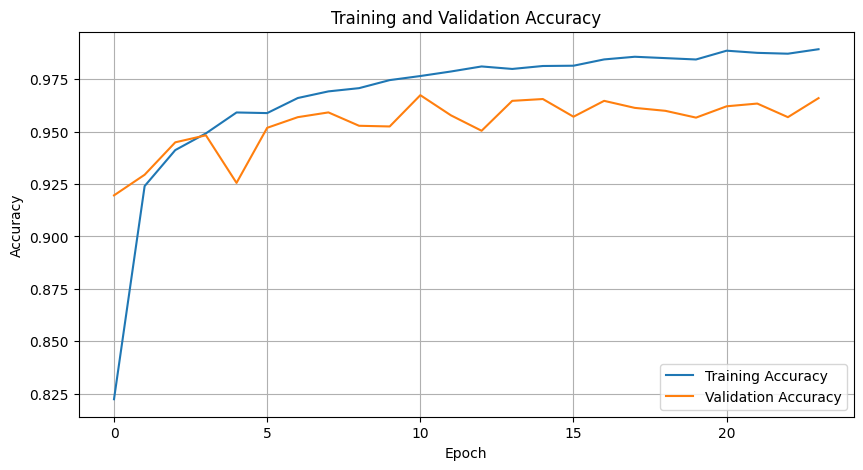

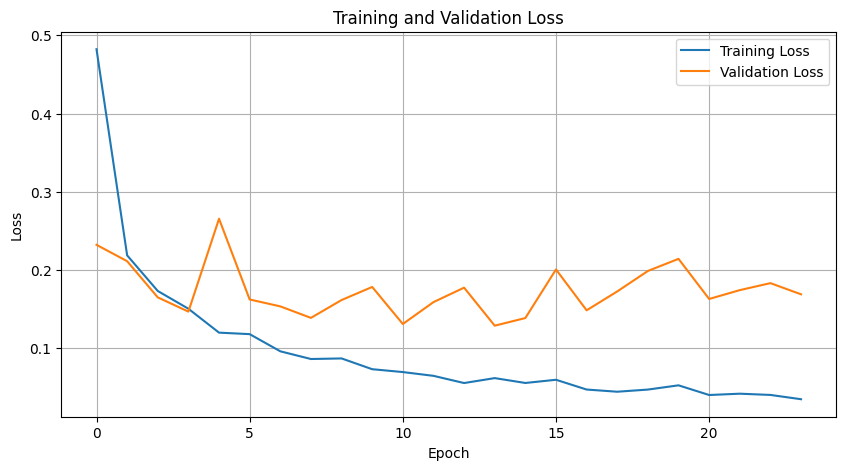

In [30]:
# Plot training and validation accuracy/loss curves
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Similar plot for loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
